# Registration test


In [316]:
import cv2 as cv
import imutils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import os

import functools
imgshowg = functools.partial(plt.imshow, cmap='gray', interpolation='none', vmin=0, vmax=255)
imgshowc = functools.partial(plt.imshow, interpolation='none', vmin=0, vmax=255)

matplotlib.rc('figure', figsize=(14, 10))

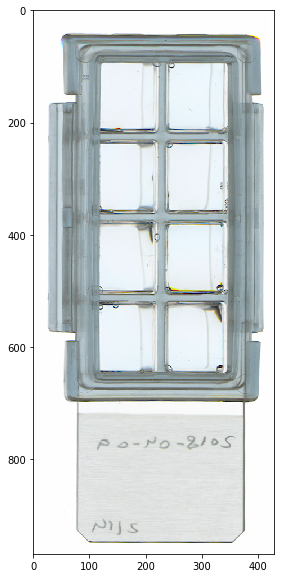

In [317]:
ref = cv.imread('./CellRef.jpg')
plt.imshow(ref)
plt.show()

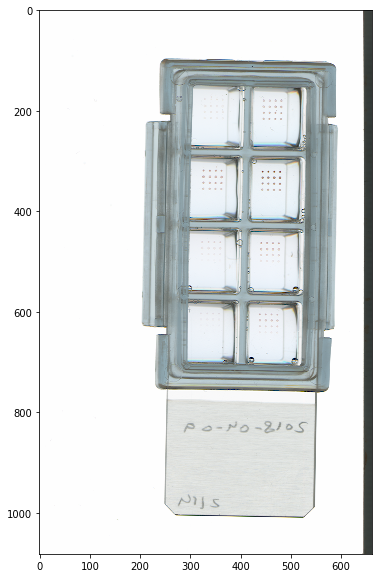

In [318]:
target = cv.imread("../test_img/04_end.tif")
plt.imshow(target)
plt.show()

In [319]:
# FROM: https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.10
 
def alignImages(im1, im2, max_features=MAX_FEATURES, good_match_percent=GOOD_MATCH_PERCENT):
  # Convert images to grayscale
  im1Gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
  im2Gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)
   
  # Detect ORB features and compute descriptors.
  orb = cv.ORB_create(max_features)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
   
  # Match features.
  matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
   
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * good_match_percent)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  imMatches = cv.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
   
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
   
  # Find homography
  h, mask = cv.findHomography(points1, points2, cv.RANSAC)
 
  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv.warpPerspective(im1, h, (width, height))
   
  return im1Reg, imMatches


In [320]:
# Folder to which to write alignment test figures
alignment_out_dir = 'alignment_tests'

# Is this stable/deterministic
for repetition in range(3):
    for max_feats in [100, 200, 300, 400, 500]:
        for good_matches in [0.05, 0.10, 0.15]:#, 0.20, 0.25]:        
            # TODO: error handling for non-matching images
            try:
                imReg, imMatches = alignImages(target, ref, max_feats, good_matches)
            except Exception as e:
                print(e)

            # Write aligned image to disk. 
            outFilename = os.path.join(alignment_out_dir, f'aligned_{max_feats}_{good_matches}_{repetition}.jpg')
            cv.imwrite(outFilename, imReg)

            outFilename = os.path.join(alignment_out_dir, f'matches_{max_feats}_{good_matches}_{repetition}.jpg')
            cv.imwrite(outFilename, imMatches)



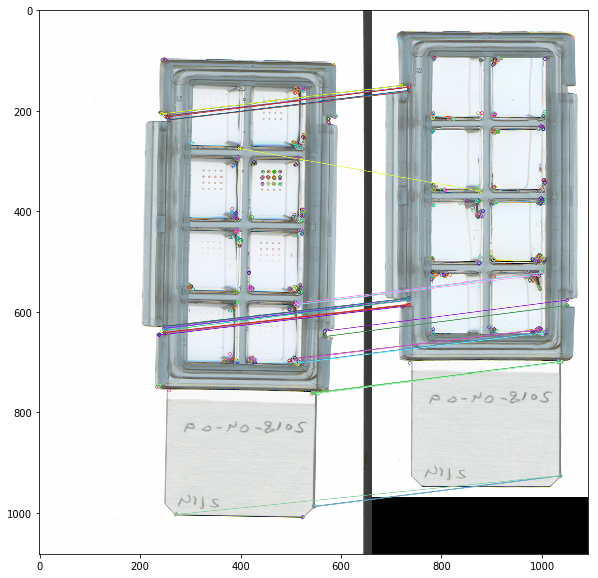

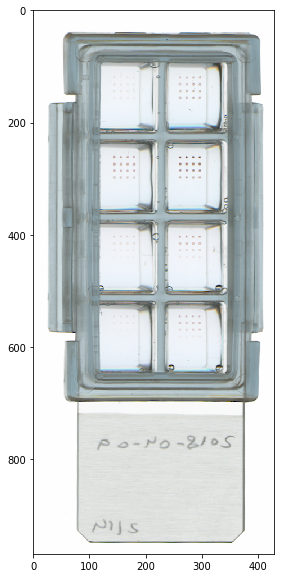

In [321]:
# Chose configuration
max_feats = 500
good_matches = 0.1
try:
    aligned, matches = alignImages(target, ref, max_feats, good_matches)
    
except Exception as e:
    print(e)

plt.imshow(matches)
plt.show()

plt.imshow(aligned)
plt.show()



In [322]:
# Extracted grid origin by hand
grid_positions = [
  [138, 114],
  [255, 114],
  [138, 256],
  [255, 256],
  [138, 398],
  [255, 398],
  [138, 540],
  [255, 540]
]

def get_grid_elements(roi, ncols=4, nrows=4):
    rows = np.split(roi, nrows, axis=0)
    cells = [np.split(row, ncols, axis=1) for row in rows]
    return np.stack(cells)

def extract_all_grids(image, grid_pos, grid_size=48):
    grids = []
    for x, y in grid_pos:
        grids.append(get_grid_elements(image[y:y+grid_size, x:x+grid_size]))
    return np.stack(grids)

In [323]:
# Load a aligned template with annoted cells in order to test point extraction
#aligned_text = cv.imread('./aligned_text.tif')
# aligned_text = cv.cvtColor(aligned_text, cv.COLOR_BGR2GRAY)

In [324]:
# Extract grids
aligned_gray = cv.cvtColor(aligned, cv.COLOR_BGR2GRAY)
#from scipy.stats import mode
#img_mode = mode(aligned_gray.ravel())[0][0]
#print(f'image_mode = {img_mode}')

grids = extract_all_grids(aligned_gray, grid_positions)

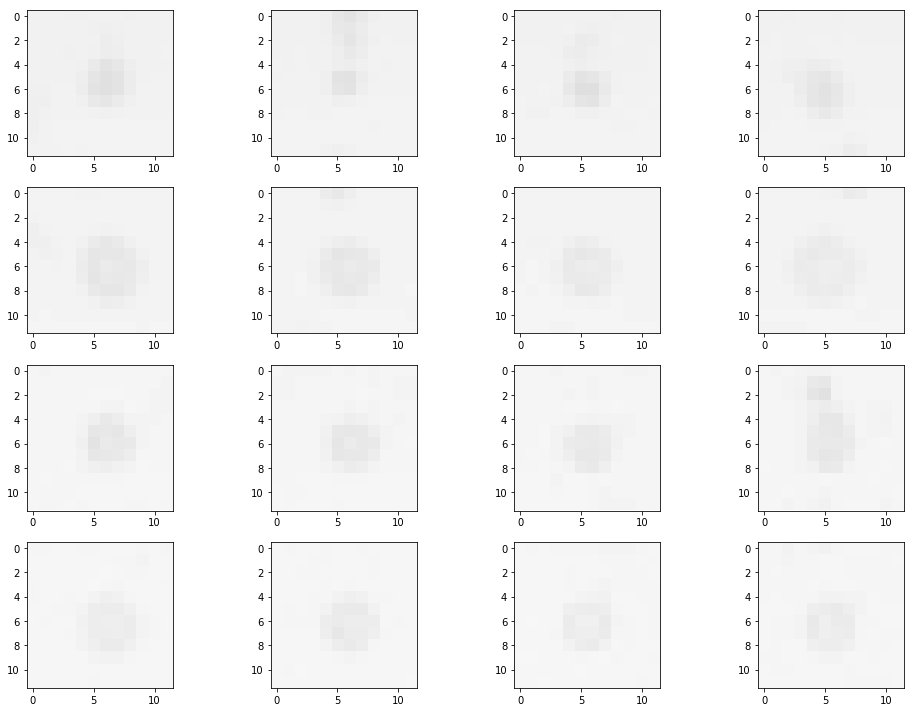

In [325]:
# Plot all points of a cell
cell = 0
plt.subplots(4, 4)
for row in range(4):
    for column in range(4):
        plt.subplot(4, 4, row*4 + column + 1)
        imgshowg(grids[cell, row, column, :, :])
    
plt.tight_layout()
plt.show()

In [326]:
# Quantify the point content for all cells

def get_top_image(image, top_ratio=0.3):
    # Inveret ratio, taking only the top
    top_ratio = min(1.0, 1.0-top_ratio)
    
    inv_img = (255 - image).ravel()
    inv_img.sort()
    
    top_elements = int(len(inv_img)*top_ratio)
    return inv_img[top_elements:]


def mean(image):
    return np.mean(255 - image)
    #return np.sum(255 - image)

def sum(image):
    return np.sum(255 - image)

    
def top_mean(image, top_ratio=0.5):
    """
    Calculate the mean intensity of the darkest 50% of the image
    """
    return np.mean(get_top_image(image, top_ratio=top_ratio))

def top_sum(image, top_ratio=5.0):
    """
    Calculate the mean intensity of the darkest 50% of the image
    """
    return np.sum(get_top_image(image, top_ratio=top_ratio))


def top_median(image, top_ratio=5.0):
    """
    Calculate the mean intensity of the darkest 50% of the image
    """
    return np.median(get_top_image(image, top_ratio=top_ratio))


quantify_point = sum


# Iterate over the grid assuming structure [grid pos, cell row, cell column, cell data]
quantgrids = np.zeros(shape=grids.shape[0:-2] + (1,))
shape = grids.shape
for grid_pos in range(shape[0]):
    for row in range(shape[1]):
        for column in range(shape[2]):
            quantgrids[grid_pos, row, column] = quantify_point(grids[grid_pos, row, column, :, :])

In [327]:
print(f'min: {quantgrids.min()}, max: {quantgrids.max()}')


min: 1469.0, max: 4148.0


In [328]:
# Transform the numpy array into a pandas.DataFrame and write it to csv
shape = quantgrids.shape
cells = np.repeat(range(shape[0]), shape[1]*shape[2])
rows = np.tile(np.repeat(range(shape[1]), shape[2]), shape[0])
columns = np.tile(np.tile(range(shape[2]), shape[1]), shape[0])
quant_table = pd.DataFrame({'cell': cells, 'row': rows, 'column': columns, 'point':quantgrids.ravel()})

In [329]:
quant_table

,cell,row,column,point
0,0,0,0,2132.0
1,0,0,1,2073.0
2,0,0,2,2045.0
3,0,0,3,2065.0
4,0,1,0,1957.0
5,0,1,1,1883.0
6,0,1,2,1766.0
7,0,1,3,1844.0
8,0,2,0,1635.0
9,0,2,1,1630.0


In [330]:
print(quantgrids[7, 1, :])

print(quantgrids[7, 2, :])

[[ 2580.]
 [ 2574.]
 [ 2572.]
 [ 2576.]]
[[ 2036.]
 [ 1980.]
 [ 1993.]
 [ 2075.]]


In [331]:
quant_table.to_csv('test_results.csv', index=False)

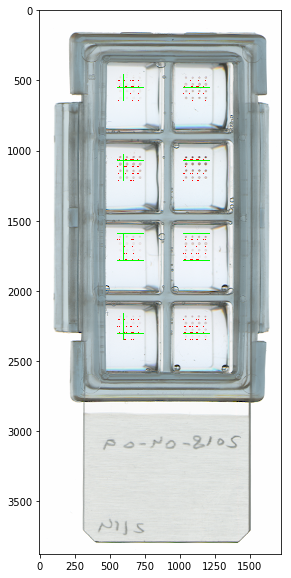

In [332]:
def label_intensities(img, grid_positions, values, grid_size=48, nrows=4, ncols=4, strformat='%.1f'):
    labeled = img.copy()
    for grid_pos,(x,y) in enumerate(grid_positions):
        cv.rectangle(labeled, (x, y), (x + grid_size, y + grid_size), (0, 255, 0), 1)
        for row in range(1, nrows):
            cv.line(labeled, (x, y + grid_size//nrows * row), (x + grid_size, y + grid_size//nrows * row), (0, 255, 0), 1)
        for col in range(1, ncols):
            cv.line(labeled, (x + grid_size//nrows * col, y), (x + grid_size//nrows * col, y + grid_size), (0, 255, 0), 1)
        for row in range(nrows):
            for col in range(ncols):
                tX = x + grid_size//nrows * col 
                tY = y + grid_size//nrows * (row + 1) - 1
                value = strformat % (values[grid_pos, row, col])

                cv.putText(labeled, value, (tX, tY), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0))
                
    return labeled

# TODO: divided by 10000 to make text fit somehow in this low res image
factor = 4
big_aligned = cv.resize(aligned, None, fx=factor, fy=factor, interpolation=cv.INTER_CUBIC)
labeled = label_intensities(big_aligned, 
                            grid_positions =[(x*factor ,y*factor) for x,y in grid_positions], 
                            values = quantgrids,
                            grid_size = factor*48,
                            #strformat = '%2.2f'
                            strformat = '%d'
                           )
cv.imwrite("labeled.png", labeled)
imgshowc(labeled)
plt.show()